In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load and preprocess data
logs_df = pd.read_csv('logs.csv')
logs_df['Timestamp'] = pd.to_datetime(logs_df['Timestamp'], format='%d %B %Y at %H:%M')
logs_df['Date'] = logs_df['Timestamp'].dt.strftime('%Y-%m-%d')
logs_df['Time'] = logs_df['Timestamp'].dt.strftime('%H:%M')
logs_df['Day of the Week'] = logs_df['Timestamp'].dt.day_name()
logs_df.drop('Timestamp', axis=1, inplace=True)
logs_df.to_csv('processed_logs.csv', index=False)

data = pd.read_csv('processed_logs.csv')
data['Datetime'] = pd.to_datetime(data.apply(lambda row: f"{row['Date']} {row['Time']}", axis=1))
data.sort_values(by='Datetime', inplace=True)

def get_intervals(data):
    away_intervals = []
    temp_out = None
    for _, row in data.iterrows():
        if row['Event Type'] == 'OUT':
            temp_out = row['Datetime']
        elif row['Event Type'] == 'IN' and temp_out is not None:
            away_intervals.append((temp_out, row['Datetime']))
            temp_out = None
    return away_intervals

intervals = get_intervals(data)

min_date = data['Datetime'].min().replace(hour=0, minute=0, second=0)
max_date = data['Datetime'].max().replace(hour=23, minute=59, second=59)
date_range = pd.date_range(start=min_date, end=max_date, freq='T')
samples = pd.DataFrame(date_range, columns=['Datetime'])

def is_away(dt, intervals):
    for start, end in intervals:
        if start <= dt <= end:
            return 1  # AWAY
    return 0  # HOME

samples['Away'] = samples['Datetime'].apply(lambda dt: is_away(dt, intervals))
samples['Hour'] = samples['Datetime'].dt.hour
samples['Day_of_Week'] = samples['Datetime'].dt.dayofweek
samples = pd.get_dummies(samples, columns=['Day_of_Week'])

In [3]:
X = samples.drop(['Away', 'Datetime'], axis=1)
y = samples['Away']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
model = SGDClassifier(loss='log', random_state=42)
model.partial_fit(X_train_scaled, y_train, classes=[0, 1])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log', random_state=42)

In [5]:
predictions = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     23235
           1       0.00      0.00      0.00      7293

    accuracy                           0.76     30528
   macro avg       0.38      0.50      0.43     30528
weighted avg       0.58      0.76      0.66     30528



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [6]:
with open('user_activity_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

/var/folders/_w/kl4xvqnd6_q9v746200yzqjw0000gn/T/ipykernel_83984/4114427059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_data['Hour'] = tuesday_data['Datetime'].dt.hour


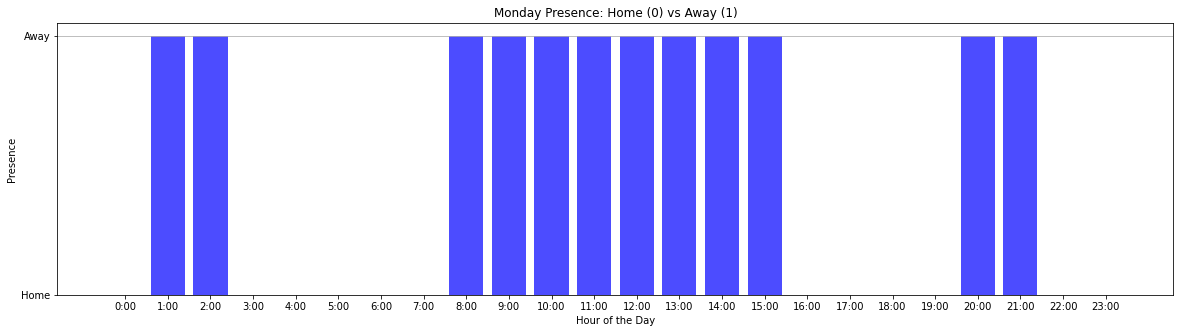

In [7]:
# Visualization
tuesday_data = samples[samples['Datetime'].dt.dayofweek == 0]
tuesday_data['Hour'] = tuesday_data['Datetime'].dt.hour
hours = tuesday_data['Hour'].unique()
away_status = [tuesday_data[tuesday_data['Hour'] == hour]['Away'].iloc[0] for hour in hours]

plt.figure(figsize=(20, 5))
plt.bar(hours, away_status, color='blue', alpha=0.7)
plt.title('Monday Presence: Home (0) vs Away (1)')
plt.xlabel('Hour of the Day')
plt.ylabel('Presence')
plt.xticks(hours, [f"{hour}:00" for hour in hours])
plt.yticks([0, 1], ['Home', 'Away'])
plt.grid(True, axis='y')
plt.show()